# Streamflow bias correction procedure

This notebook contains analysis to improve the bias correction procedure that is used for daily streamflow with a particular application to climate change 

## Setup

### magic

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

### imports

In [2]:
import pandas as pd
import xarray as xr
import matplotlib as mpl
import seaborn as sns
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import calendar
import os

### plot defaults

In [3]:
colors = ["ocean", "amber", "rose", "orange", "eggplant"]
sns.set_palette(sns.xkcd_palette(colors))
sns.set_style('whitegrid')
sns.set_context('notebook')

### paths

In [4]:
base_path = '/Users/nijssen/Dropbox/data/bpa'
out_path = os.path.join(base_path, 'streamflow-provisional_0.2', 'tmp')
historical_path = os.path.join(base_path, 'streamflow-provisional_0.2',
                               'historical_livneh-streamflow-provisional_0.2')
modeled_path = os.path.join(base_path, 'streamflow-provisional_0.2', 
                            '{GCM}_{scenario}-streamflow-provisional_0.2')
nrni_file = os.path.join(base_path, 'nrni', 'NRNI_20150318_clean_fixed_MRS-prepped-reformatted.nc')
historical_bc_model_file_template = os.path.join(historical_path, 'bias_correction',
                                   'historical_livneh_{hydro}_P1-{site}-biascorrected_streamflow-provisional_0.2.csv')
historical_raw_model_file_template = os.path.join(historical_path, 'raw',
                                   'historical_livneh_{hydro}_P1-{site}-streamflow-provisional_0.2.csv')
bc_model_file_template = os.path.join(modeled_path, 'biascorrected',
                                      '{GCM}_{scenario}_{downscaling}_{hydro}_P1-{site}-biascorrected_streamflow-provisional_0.2.csv')
raw_model_file_template = os.path.join(modeled_path, 'raw',
                                       '{GCM}_{scenario}_{downscaling}_{hydro}_P1-{site}-streamflow-provisional_0.2.csv')
site_file_template_hist = os.path.join(out_path, '{site}_{hydro}_{filetype}.{extension}')
site_file_template_gcm = os.path.join(out_path, '{site}_{hydro}_{filetype}_{GCM}_{scenario}_{downscaling}.{extension}')

## Utility Functions

### retrieve data from file

In [5]:
def get_nrni(site, nrni_file=nrni_file):
    '''Retrieve NRNI streamflow from file by site index'''
    nrni = xr.open_dataset(nrni_file)
    nrni.coords['time'] = nrni.Time
    nrni = nrni.Streamflow[nrni.IndexNames==site,:]
    nrni = nrni[0,].drop('index')
    nrni = nrni.to_dataframe()
    nrni = nrni.rename(columns={'Streamflow':'streamflow'})
    return nrni

In [6]:
def get_model_flow(sitedata, raw, na_values='-9999', comment='#'):
    '''Retrieve modeled GCM-based streamflow from file by site index'''
    if raw:
        model_file_template = raw_model_file_template
    else:
        model_file_template = bc_model_file_template
    x = pd.read_csv(model_file_template.format(**sitedata), 
                    comment=comment, na_values=na_values, index_col=0, parse_dates=True)
    if not raw:
        x = x.rename(columns={'biascorrected_streamflow':'streamflow'})
    return x

In [7]:
def get_hist_flow(sitedata, raw, na_values='-9999', comment='#'):
    '''Retrieve modeled historic forcings based streamflow from file by site index'''
    if raw:
        model_file_template = historical_raw_model_file_template
    else:
        model_file_template = historical_bc_model_file_template
    x = pd.read_csv(model_file_template.format(**sitedata), 
                    comment=comment, na_values=na_values, index_col=0, parse_dates=True)
    if not raw:
        x = x.rename(columns={'biascorrected_streamflow':'streamflow'})
    return x

### write output to file

In [8]:
def write_site(sitedata, nrni, hraw, hbc, raw, bias):
    df = pd.DataFrame({'nrni': nrni.streamflow, 'hraw': hraw.streamflow, 'raw': raw.streamflow, 
                       'hbc': hbc.streamflow, 'bc': bc.streamflow})
    outfile = site_file_template_gcm.format(**sitedata, filetype='data', extension='csv')
    with open(outfile, 'w') as f:
        f.write('# Provisional data 0.2: not for distribution\n')
        f.write('# Bart Nijssen, nijssen@uw.edu\n')
        f.write('# location: GCM, RCP, downscaling method, hydrological model\n')
        f.write('# {}: {} {} {} {}\n'.format(sitedata['site'], sitedata['GCM'], 
                                         sitedata['scenario'], sitedata['downscaling'],
                                         sitedata['hydro']))
        f.write('# Column 1: nrni - no regulation, no irrigation (naturalized)\n')
        f.write('# Column 2: hraw - raw model simulations based on historic forcings (Livneh et al. 2013)\n')
        f.write('# Column 3: hbc - bias corrected model simulations based on historic forcings (Livneh et al. 2013)\n')
        f.write('# Column 4: raw - raw model simulations based on GCM forcings\n')
        f.write('# Column 5: bc - bias corrected model simulations based on GCM forcings\n')
        f.write('# The bias corrected forcings are the raw values bias-corrected to nrni\n')
        f.write('# Units: cfs\n')
        f.write(df.to_csv(index_label='date',na_rep='NaN',float_format='%g',columns=['nrni','hraw','hbc','raw','bc']))   

### plotting helper functions

In [9]:
def fdc(data, label, ax, **kwargs):
    '''plotting positions for flow duration curve'''
    data = np.sort(data)
    ranks = stats.rankdata(data, method='average')[::-1]
    quant = (ranks-0.4)/(data.size+0.2) # Cunnane plotting position
    ax.plot(stats.norm.ppf(quant), data, label=label, **kwargs) # plot on probability axis to stretch extremes

In [10]:
def period_label(period):
    if period in ['month', 'M']:
        return 'monthly'
    elif period in ['week', 'W']:
        return 'weekly'
    elif period in ['day', 'dayofyear', 'D']:
        return 'daily'
    else:
        raise ValueError('unknown period: {}'.format(period))

## Analysis

### site info

In [31]:
sitedata = {'GCM': 'CCSM4', 
            'scenario': 'rcp85', 
            'downscaling': 'BCSD', 
            'hydro': 'VIC', 
            'site': 'PARW'}
nrni = get_nrni(sitedata['site'])
raw = get_model_flow(sitedata, raw=True)
bc = get_model_flow(sitedata, raw=False)
hraw = get_hist_flow(sitedata, raw=True)
hbc = get_hist_flow(sitedata, raw=False)

### period info

In [32]:
control = slice('1950-10-01', '2005-09-30') # control period used to develop the quantile mapping
historic = slice('1971-10-01', '2000-09-30') # 30-year historic climate normal period
future = slice('2069-10-01', '2099-09-30') # 30-year future climate normal period

### Observed forcings: Sample time series - raw and bias-corrected flows

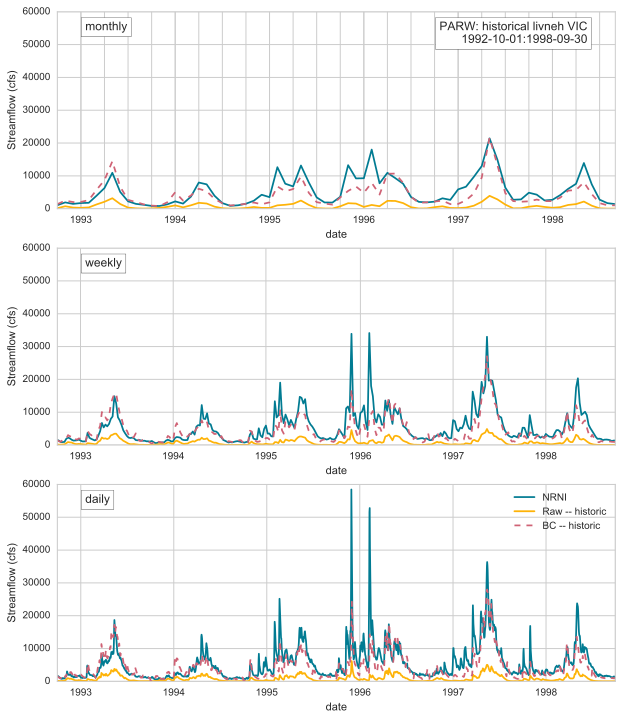

In [33]:
window = slice('1992-10-01','1998-09-30') # illustrative sample period
fig, axes = plt.subplots(3, 1, sharey=True, figsize=(10,12))

for ax, period in zip(axes, ['M', 'W', 'D']):
    nrni.streamflow[window].resample(period).mean().plot(ax=ax, label='NRNI')
    hraw.streamflow[window].resample(period).mean().plot(ax=ax, label='Raw -- historic')
    hbc.streamflow[window].resample(period).mean().plot(ax=ax, label='BC -- historic', ls='--')
    ax.set_ylabel('Streamflow (cfs)')
    ax.text(0.05, 0.95, '{}'.format(period_label(period)),
             horizontalalignment='left', verticalalignment='top', 
             transform=ax.transAxes, bbox=dict(facecolor='white'))    
    if period == 'M':
        plt.sca(ax)
        plt.grid(b=True, axis='both', which='minor')


plt.sca(ax)
plt.legend()
axes[0].text(0.95, 0.95, '{site}: historical livneh {hydro}\n{start}:{stop}'.format(**sitedata, 
                                                                                    start=window.start, 
                                                                                    stop=window.stop), 
             horizontalalignment='right', verticalalignment='top', 
             transform=axes[0].transAxes, bbox=dict(facecolor='white'))
plt.savefig(site_file_template_hist.format(**sitedata, filetype='plot_1', extension='pdf'))

### Observed forcings: period-averaged annual cycle - raw and bias-corrected flows

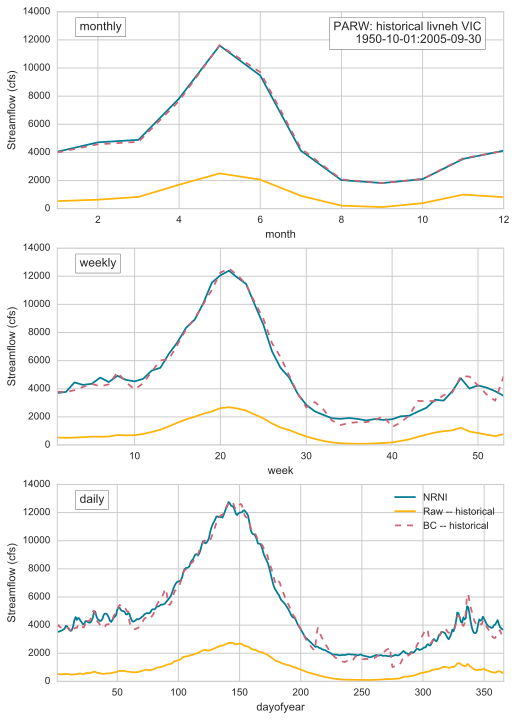

In [34]:
fig, axes = plt.subplots(3, 1, sharey=True, figsize=(8,12))
for ax, period in zip(axes, ['month', 'week', 'dayofyear']):
    nrni.streamflow[control].groupby(getattr(nrni[control].index, period)).mean().plot(ax=ax, label='NRNI')
    hraw.streamflow[control].groupby(getattr(raw[control].index, period)).mean().plot(ax=ax, label='Raw -- historical')
    hbc.streamflow[control].groupby(getattr(bc[control].index, period)).mean().plot(ax=ax, ls='--', label='BC -- historical')
    ax.set_xlabel(period)
    ax.set_ylabel('Streamflow (cfs)')
    
    if period == 'dayofyear':
        label = 'daily'
    else:
        label = '{}ly'.format(period)    
    ax.text(0.05, 0.95, '{}'.format(label),
             horizontalalignment='left', verticalalignment='top', 
             transform=ax.transAxes, bbox=dict(facecolor='white'))    

plt.legend()
axes[0].text(0.95, 0.95, '{site}: historical livneh {hydro}\n{start}:{stop}'.format(**sitedata,
                                                                                    start=control.start, 
                                                                                    stop=control.stop), 
             horizontalalignment='right', verticalalignment='top', 
             transform=axes[0].transAxes, bbox=dict(facecolor='white'))
plt.savefig(site_file_template_hist.format(**sitedata, filetype='plot_2', extension='pdf'))

### GCM forcings: kernel density estimate - raw and bias corrected flows - future and control simulations

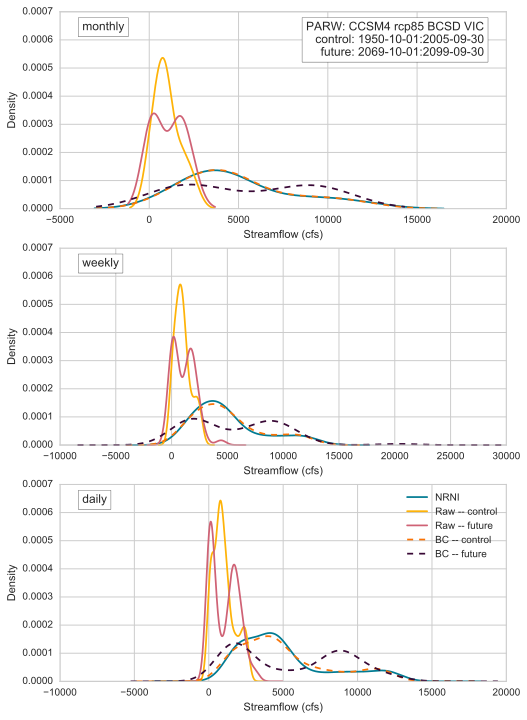

In [35]:
fig, axes = plt.subplots(3, 1, sharey=True, figsize=(8,12))

for ax, period in zip(axes, ['month', 'week', 'dayofyear']):
    nrni.streamflow[control].groupby(getattr(nrni[control].index, period)).mean().plot.kde(ax=ax, label='NRNI')
    raw.streamflow[control].groupby(getattr(raw[control].index, period)).mean().plot.kde(ax=ax, label='Raw -- control')
    raw.streamflow[future].groupby(getattr(raw[future].index, period)).mean().plot.kde(ax=ax, label='Raw -- future')
    bc.streamflow[control].groupby(getattr(bc[control].index, period)).mean().plot.kde(ax=ax, ls='--', label='BC -- control')
    bc.streamflow[future].groupby(getattr(bc[future].index, period)).mean().plot.kde(ax=ax, ls='--', label='BC -- future')
    ax.set_xlabel('Streamflow (cfs)')
    ax.text(0.05, 0.95, '{}'.format(period_label(period)),
             horizontalalignment='left', verticalalignment='top', 
             transform=ax.transAxes, bbox=dict(facecolor='white'))    

plt.legend()
axes[0].text(0.95, 0.95, '{site}: {GCM} {scenario} {downscaling} {hydro}\ncontrol: {start}:{stop}\nfuture: {fstart}:{fstop}'.format(
             **sitedata, start=control.start, stop=control.stop, fstart=future.start, fstop=future.stop),
             horizontalalignment='right', verticalalignment='top', 
             transform=axes[0].transAxes, bbox=dict(facecolor='white'))
plt.savefig(site_file_template_gcm.format(**sitedata, filetype='plot_3', extension='pdf'))

### GCM forcings: period-averaged annual cycle - raw and bias-corrected flows - future and control simulations

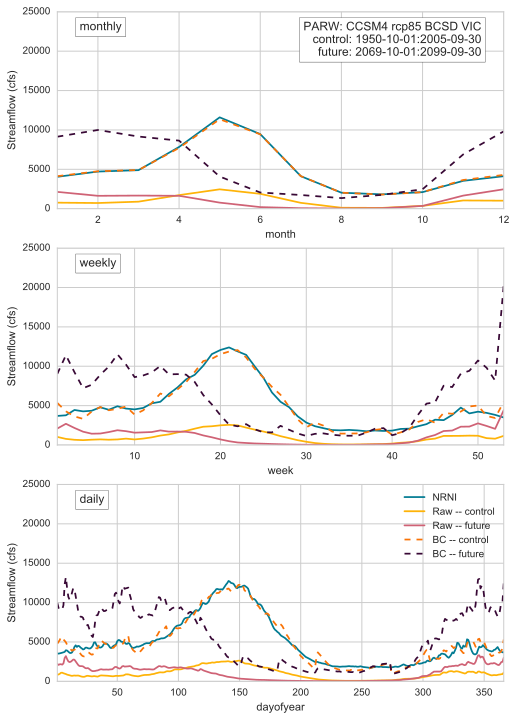

In [36]:
fig, axes = plt.subplots(3, 1, sharey=True, figsize=(8,12))
for ax, period in zip(axes, ['month', 'week', 'dayofyear']):
    nrni.streamflow[control].groupby(getattr(nrni[control].index, period)).mean().plot(ax=ax, label='NRNI')
    raw.streamflow[control].groupby(getattr(raw[control].index, period)).mean().plot(ax=ax, label='Raw -- control')
    raw.streamflow[future].groupby(getattr(raw[future].index, period)).mean().plot(ax=ax, label='Raw -- future')
    bc.streamflow[control].groupby(getattr(bc[control].index, period)).mean().plot(ax=ax, ls='--', label='BC -- control')
    bc.streamflow[future].groupby(getattr(bc[future].index, period)).mean().plot(ax=ax, ls='--', label='BC -- future')
    ax.set_xlabel(period)
    ax.set_ylabel('Streamflow (cfs)')
    ax.text(0.05, 0.95, '{}'.format(period_label(period)),
             horizontalalignment='left', verticalalignment='top', 
             transform=ax.transAxes, bbox=dict(facecolor='white'))    

plt.legend()
axes[0].text(0.95, 0.95, '{site}: {GCM} {scenario} {downscaling} {hydro}\ncontrol: {start}:{stop}\nfuture: {fstart}:{fstop}'.format(
             **sitedata, start=control.start, stop=control.stop, fstart=future.start, fstop=future.stop),
             horizontalalignment='right', verticalalignment='top', 
             transform=axes[0].transAxes, bbox=dict(facecolor='white'))
plt.savefig(site_file_template_gcm.format(**sitedata, filetype='plot_4', extension='pdf'))

### GCM forcings: period-averaged annual cycle - raw and bias-corrected flows - ratio of future to reference simulations

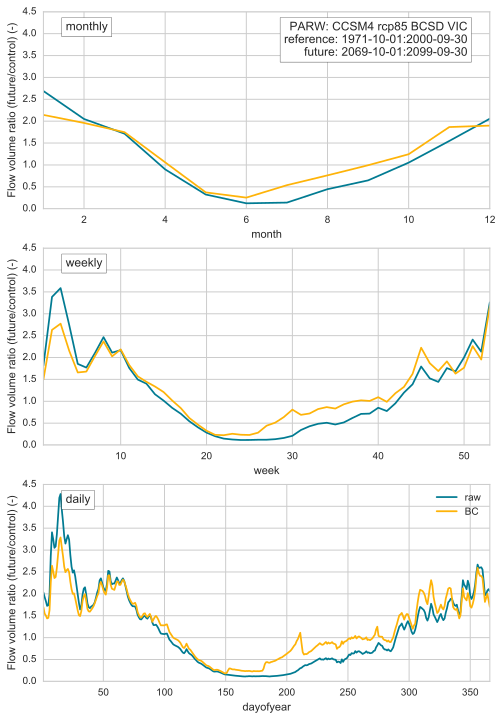

In [37]:
fig, axes = plt.subplots(3, 1, sharey=True, figsize=(8,12))
for ax, period in zip(axes, ['month', 'week', 'dayofyear']):
    raw_ratio = raw.streamflow[future].groupby(getattr(raw[future].index, period)).mean() / \
                raw.streamflow[historic].groupby(getattr(raw[historic].index, period)).mean()
    bc_ratio = bc.streamflow[future].groupby(getattr(bc[future].index, period)).mean() / \
               bc.streamflow[historic].groupby(getattr(bc[historic].index, period)).mean()
    raw_ratio.plot(ax=ax, label='raw')
    bc_ratio.plot(ax=ax, label='BC')

    ax.set_xlabel(period)
    ax.set_ylabel('Flow volume ratio (future/control) (-)')
    ax.text(0.05, 0.95, '{}'.format(period_label(period)),
             horizontalalignment='left', verticalalignment='top', 
             transform=ax.transAxes, bbox=dict(facecolor='white'))    

plt.legend()
axes[0].text(0.95, 0.95, '{site}: {GCM} {scenario} {downscaling} {hydro}\nreference: {start}:{stop}\nfuture: {fstart}:{fstop}'.format(
             **sitedata, start=historic.start, stop=historic.stop, fstart=future.start, fstop=future.stop),
             horizontalalignment='right', verticalalignment='top', 
             transform=axes[0].transAxes, bbox=dict(facecolor='white'))

plt.savefig(site_file_template_gcm.format(**sitedata, filetype='plot_5', extension='pdf'))

### Observed forcings: Flow duration curves - raw and bias-corrected flows

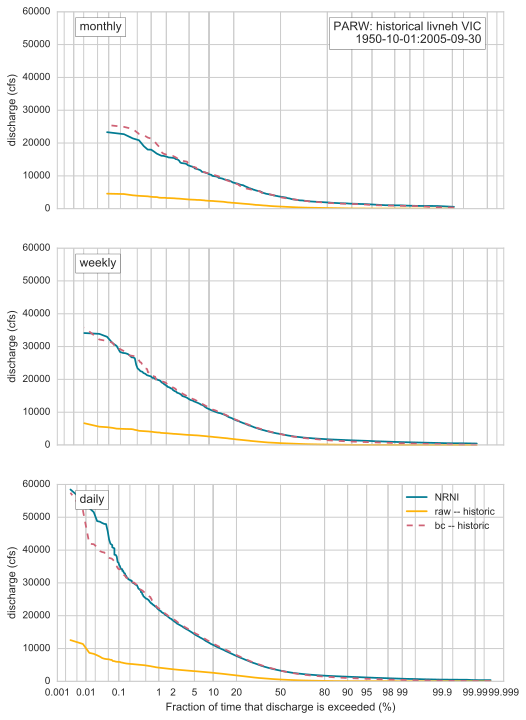

In [38]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(8,12))
for ax, period in zip(axes, ['M', 'W', 'D']):
    fdc(nrni[control].streamflow.resample(period).mean(), 'NRNI', ax=ax)
    fdc(hraw[control].streamflow.resample(period).mean(), 'raw -- historic', ax=ax)
    fdc(hbc[control].streamflow.resample(period).mean(), 'bc -- historic', ax=ax, ls='--')

    xminorticks = [0.00001, 0.00002, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, .01, .02, .05, .10, .20, .50,
                   0.80, 0.90, 0.95, 0.98, 0.99, 0.995, 0.098, 0.999, 0.9995, 0.0998, 0.9999, 0.99995, 0.09998, 0.99999]
    ax.set_xticks(stats.norm.ppf(xminorticks), minor=True)

    xmajorticks = [0.00001, 0.0001, 0.001,.01,.02,.05,.10,.20,.50,.80,.90,.95,.98,.99, 0.999, 0.9999, 0.99999]
    xticklabels = ['{0:g}'.format(100*x) for x in xmajorticks]
    ax.set_xticks(stats.norm.ppf(xmajorticks), minor=False)

    ax.set_xticklabels(xticklabels)
    ax.set_ylabel('discharge (cfs)')
    ax.grid(True, which='both')
    ax.text(0.05, 0.95, '{}'.format(period_label(period)),
             horizontalalignment='left', verticalalignment='top', 
             transform=ax.transAxes, bbox=dict(facecolor='white'))    

plt.legend()
plt.xlabel('Fraction of time that discharge is exceeded (%)')
axes[0].text(0.95, 0.95, '{site}: historical livneh {hydro}\n{start}:{stop}'.format(**sitedata,
                                                                                    start=control.start, 
                                                                                    stop=control.stop), 
             horizontalalignment='right', verticalalignment='top', 
             transform=axes[0].transAxes, bbox=dict(facecolor='white'))
plt.savefig(site_file_template_hist.format(**sitedata, filetype='plot_6', extension='pdf'))

### GCM forcings: Flow duration curves - raw and bias-corrected flows - future and control simulations

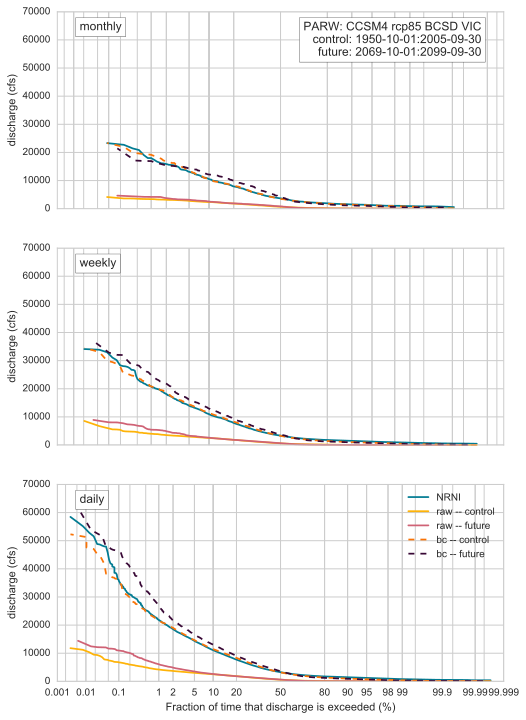

In [39]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(8,12))
for ax, period in zip(axes, ['M', 'W', 'D']):
    fdc(nrni[control].streamflow.resample(period).mean(), 'NRNI', ax=ax)
    fdc(raw[control].streamflow.resample(period).mean(), 'raw -- control', ax=ax)
    fdc(raw[future].streamflow.resample(period).mean(), 'raw -- future', ax=ax)
    fdc(bc[control].streamflow.resample(period).mean(), 'bc -- control', ax=ax, ls='--')
    fdc(bc[future].streamflow.resample(period).mean(), 'bc -- future', ax=ax, ls='--')

    xminorticks = [0.00001, 0.00002, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, .01, .02, .05, .10, .20, .50,
                   0.80, 0.90, 0.95, 0.98, 0.99, 0.995, 0.098, 0.999, 0.9995, 0.0998, 0.9999, 0.99995, 0.09998, 0.99999]
    ax.set_xticks(stats.norm.ppf(xminorticks), minor=True)

    xmajorticks = [0.00001, 0.0001, 0.001,.01,.02,.05,.10,.20,.50,.80,.90,.95,.98,.99, 0.999, 0.9999, 0.99999]
    xticklabels = ['{0:g}'.format(100*x) for x in xmajorticks]
    ax.set_xticks(stats.norm.ppf(xmajorticks), minor=False)

    ax.set_xticklabels(xticklabels)
    ax.set_ylabel('discharge (cfs)')
    ax.grid(True, which='both')
    ax.text(0.05, 0.95, '{}'.format(period_label(period)),
             horizontalalignment='left', verticalalignment='top', 
             transform=ax.transAxes, bbox=dict(facecolor='white'))    



plt.legend()
plt.xlabel('Fraction of time that discharge is exceeded (%)')
axes[0].text(0.95, 0.95, 
             '{site}: {GCM} {scenario} {downscaling} {hydro}\ncontrol: {start}:{stop}\nfuture: {fstart}:{fstop}'.format(
             **sitedata, start=control.start, stop=control.stop, fstart=future.start, fstop=future.stop),
             horizontalalignment='right', verticalalignment='top', 
             transform=axes[0].transAxes, bbox=dict(facecolor='white'))

plt.savefig(site_file_template_gcm.format(**sitedata, filetype='plot_7', extension='pdf'))

### write sample data to file for others to use

In [40]:
write_site(sitedata, nrni, hraw, hbc, raw, bc)